In [1]:
# !pip install gensim==3.8.3
# !pip install pyLDAvis==3.3.1

In [2]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from IPython.display import HTML, display
import tabulate
import pandas as pd
import numpy as np
from PIL import Image
from wordcloud import WordCloud
import seaborn as sns
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis

# from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer, PorterStemmer
# from nltk.stem.porter import *

import gensim
from gensim.models import Phrases
#Prepare objects for LDA gensim implementation
from gensim import corpora
#Running LDA
from gensim import models

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import re
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [3]:
data=pd.read_csv('./omicron_tweets.csv', engine='python')
# dropping empty rows
data = data.dropna(subset=['text'])
# dropping duplicates
data = data.drop_duplicates()
print('Rows: {}, columns: {}'.format(data.shape[0], data.shape[1]))
data.head(2)

Rows: 8066, columns: 13


,tweet_id,date,text,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,hashtags,source,is_retweet
0,1465162850457071621,2021-11-29 03:36:59+00:00,Will Boris Johnson ever learn his lesson after...,James robertson,NaN,NaN,2013-04-22 19:41:30+00:00,303.0,188,84059,NaN,Twitter for Android,False
1,1465162841665769474,2021-11-29 03:36:57+00:00,#Omicron so hot; it’s being rush shipped in De...,Gene Bulmer,East Coast,"#ChristFollower, #Leader, Husband, Father, #Ru...",2014-11-10 22:43:27+00:00,99.0,162,745,['Omicron'],Twitter for iPhone,False


<b> Data Manipulation </b>

In [4]:
data['processed'] = ''
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = stopwords.words('english')

stop_words.extend(['https'])
# initalizing the werdnet lemmatizer
lm = WordNetLemmatizer()

def processing(content):

    content = content.replace('\n', ' ').split(' ')
#  removing these punctuations from tokens like it will convert the word mode? into mode
    rx = re.compile('([&#.:?!-()])*')
    content = [rx.sub('', word) for word in content]
    
#  removing stopwords
    content = [word.strip().lower() for word in content if word.strip().lower() not in stop_words]
  #  remove words whose length is greater than 1 and or alphabetics only 
    content = [word for word in content if len(word)>1 and word.isalpha()]
    # lemmatizing the words to their basic form
    content = [lm.lemmatize(word) for word in content]

    return ' '.join(content)

for k in range(len(data)):
  data.iloc[k,-1] = processing(data.iloc[k,2])
# processed data
data.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,tweet_id,date,text,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,hashtags,source,is_retweet,processed
0,1465162850457071621,2021-11-29 03:36:59+00:00,Will Boris Johnson ever learn his lesson after...,James robertson,NaN,NaN,2013-04-22 19:41:30+00:00,303.0,188,84059,NaN,Twitter for Android,False,boris johnson ever learn lesson endless covid ...
1,1465162841665769474,2021-11-29 03:36:57+00:00,#Omicron so hot; it’s being rush shipped in De...,Gene Bulmer,East Coast,"#ChristFollower, #Leader, Husband, Father, #Ru...",2014-11-10 22:43:27+00:00,99.0,162,745,['Omicron'],Twitter for iPhone,False,omicron rush shipped package symptom barely kn...
2,1465162837047726094,2021-11-29 03:36:56+00:00,@JoeBiden How To Stop The Spread of Coronaviru...,Andrew Arcie Galendez (ᚪᚾᛞᚱᛖᚹ᛫),NaN,I AM PURE FILIPINO; BOTH MY PARENTS ARE FILIPI...,2021-01-28 11:31:59+00:00,114.0,3223,4830,NaN,Twitter for Android,False,stop spread coronavirus omicron variant delta ...
3,1465162836498432005,2021-11-29 03:36:56+00:00,Gold Coast leaders urge against overcautious r...,myGC.com.au,"Gold Coast, Australia","The Gold Coast's best news, local events, weat...",2009-03-30 03:54:34+00:00,12232.0,3191,271,['GoldCoastNews'],Zapier.com,False,gold coast leader urge overcautious response o...
4,1465162831444119562,2021-11-29 03:36:55+00:00,What Is Omicron Radiation...\nhttps://t.co/QfK...,Ghost Of Gus Hall,Poughkeepsie Peoples Republic,Freelancer who knows a name and is lying to po...,2011-10-17 03:25:39+00:00,603.0,960,819,NaN,Twitter for Android,False,omicron radiation


<b>Word Cloud </b>

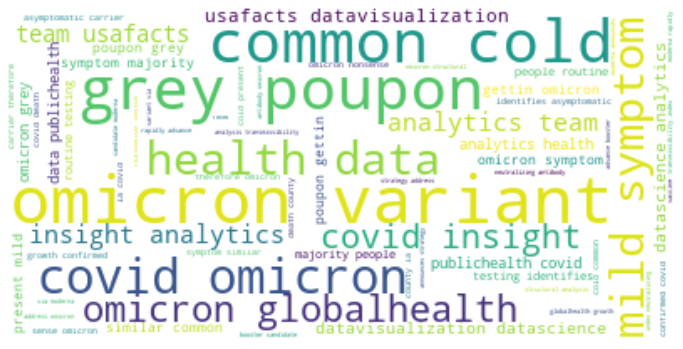

In [5]:
b = data['processed'].tolist()
b = ' '.join(map(str, b))
# b = b.replace(',', ' ').lower().replace('-', '')

wordcloud = WordCloud(max_font_size=40, max_words=1000, background_color="white", random_state=100,
                      prefer_horizontal=0.60).generate(b.lower())
# max_font_size=40, max_words=1000, background_color="white",
                      # random_state=100, prefer_horizontal=0.50
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
# plt.show()
plt.savefig('word_cloud.jpg')

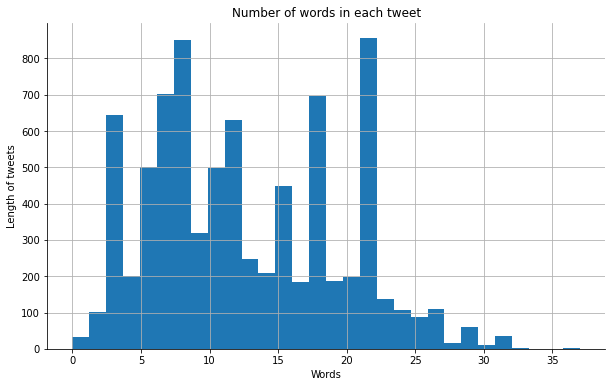

In [6]:
lengths = [len(sentence.split(' ')) if len(sentence)>0 else 0 for sentence in data['processed']]
data['Lengths'] = lengths
plt.figure(figsize=(10,6))
data['Lengths'].hist(bins=30)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.title('Number of words in each tweet')
plt.xlabel('Words')
plt.ylabel('Length of tweets')
plt.savefig('length_tweets.jpg')
plt.show()

In [7]:
import gensim.corpora as corpora

#decomposing sentences into tokens
tokens = [sentence.split(' ') for sentence in data['processed'] ]
# training a bi gram model in order to include those bigrams as tokens who occured at least 6 times
# in the whole dataset
bigram = gensim.models.Phrases(tokens, min_count=2, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

# including bigrams as tokens 
sents = [ bigram_mod[token] for token in tokens]

# Create Dictionary to keep track of vocab
dct = corpora.Dictionary(tokens)

print('Unique words before filtering/after pre-processing', len(dct))
# no_below= 30
# filter the words that occure in less than 3 documents and in more the 60% of documents
dct.filter_extremes(no_below= 3, no_above=0.60 )
print('Unique words after filtering', len(dct))

# Create Corpus
corpus = [dct.doc2bow(sent) for sent in sents]

tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

Unique words before filtering/after pre-processing 9834
Unique words after filtering 3263


In [8]:
%%time
from gensim.models import CoherenceModel
import time
import os

scores = []
for k in range(3,15):
    # LDA model
    lda_model = gensim.models.LdaModel(  corpus=corpus_tfidf, num_topics=k,
                                                 id2word=dct, random_state=12)
    # to calculate score for coherence
    coherence_model_lda = CoherenceModel(model=lda_model, texts=sents, dictionary=dct, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print(k, coherence_lda)
    scores.append(coherence_lda)

3 0.5488264668187827
4 0.4065263368076506
5 0.43498981193412023
6 0.4598313128230022
7 0.41688548620270843
8 0.48115228053009207
9 0.4608086515564191
10 0.4820849819803641
11 0.3976712431810696
12 0.4227588296332713
13 0.45360036270778586
14 0.48519719309739046
CPU times: user 31.9 s, sys: 516 ms, total: 32.5 s
Wall time: 31.9 s


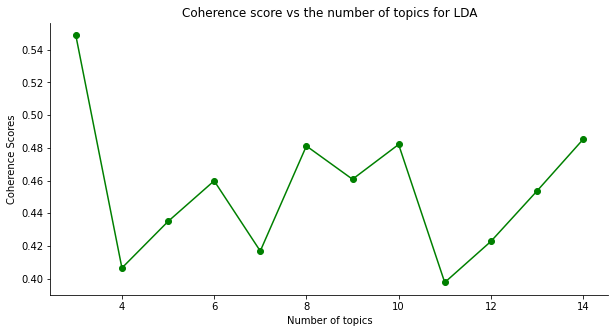

In [9]:
selected_topics = np.argmax(scores)+3

plt.figure(figsize=(10, 5))
plt.plot(list(range(3,15)), scores, marker='o', color='green')
sns.despine(top=True, right=True, left=False, bottom=False)

plt.locator_params(integer=True)
plt.title('Coherence score vs the number of topics for LDA')
plt.xlabel('Number of topics')
plt.ylabel('Coherence Scores')
plt.savefig('lda_scores.jpg')
plt.show()

In [10]:
import pyLDAvis.gensim_models

lda_model = gensim.models.LdaModel(corpus=corpus_tfidf, id2word=dct, num_topics=selected_topics, 
                                           random_state=12, chunksize=128, passes=10 )

pyLDAvis.enable_notebook()
results = pyLDAvis.gensim_models.prepare(lda_model, corpus_tfidf, dct, sort_topics=False)
pyLDAvis.save_html(results, 'ldavis_english' +'.html')
results

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.353196 -0.001704       1        1  21.008356
1     -0.179421 -0.159039       2        1  24.364480
2     -0.173775  0.160743       3        1  54.627164, topic_info=                   Term        Freq       Total Category  logprob  loglift
2                 covid  465.000000  465.000000  Default  30.0000  30.0000
3122          analytics  390.000000  390.000000  Default  29.0000  29.0000
897                  la  199.000000  199.000000  Default  28.0000  28.0000
3124  datavisualization  195.000000  195.000000  Default  27.0000  27.0000
3125           usafacts  195.000000  195.000000  Default  26.0000  26.0000
...                 ...         ...         ...      ...      ...      ...
142                news   39.414132   46.846013   Topic3  -5.5964   0.4319
2678     omicronvarient   55.997223   91.951839   Topic3  -5.2453   0.1087
472      omicronvariant   44.816293   74.861390   Topic3  -5.4680   0.0916
289                 get   37.472424   44.496540   Topic3  -5.6469   0.4328
212                   u   44.316617  212.285007   Topic3  -5.4792  -0.9619

[141 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2785      2  0.951018    amazing
3122      1  0.998471  analytics
3122      2  0.002560  analytics
410       2  0.975993     anyone
355       2  0.981135     auspol
...     ...       ...        ...
249       3  0.643772        via
1383      1  0.657910        win
1383      2  0.328955        win
220       2  0.013295       york
220       3  0.997157       york

[204 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

In [11]:
# top words in each topic
lda_model.print_topics()

[(0,
  '0.106*"covid" + 0.095*"analytics" + 0.049*"la" + 0.048*"usafacts" + 0.048*"datascience" + 0.048*"datavisualization" + 0.048*"globalhealth" + 0.048*"county" + 0.048*"growth" + 0.048*"publichealth"'),
 (1,
  '0.008*"mask" + 0.008*"like" + 0.008*"omicronvarient" + 0.006*"minnesota" + 0.006*"omicronvariant" + 0.006*"think" + 0.005*"maskup" + 0.005*"anyone" + 0.004*"auspol" + 0.004*"biden"'),
 (2,
  '0.017*"case" + 0.012*"new" + 0.012*"variant" + 0.007*"york" + 0.006*"first" + 0.006*"vaccine" + 0.006*"state" + 0.006*"detected" + 0.006*"coronavirus" + 0.005*"omicronvarient"')]

<center><h2> Non-Negative Matrix Factorization (NMF) </h2> </center>
<br>

In [12]:
from gensim.models.nmf import Nmf

scores_nmf = []
for k in range(3,15):
    # lda mallet model
    nmf_model = Nmf(corpus_tfidf, num_topics=k, \
                                  id2word=dct, \
                                  passes=10)
    # to calculate score for coherence
    coherence_model_lda = CoherenceModel(model=nmf_model, texts=sents, dictionary=dct, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print(k, coherence_lda)
    scores_nmf.append(coherence_lda)

3 0.4833587299342517
4 0.4294732640186358
5 0.42575335103218387
6 0.45166995028107637
7 0.44672568616474745
8 0.47619018539501934
9 0.39478784332845973
10 0.43190443458258
11 0.4478374752918233
12 0.4517428081418509
13 0.4111458572820349
14 0.4106878119451626


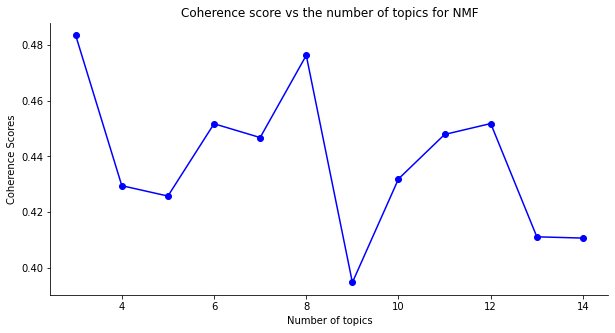

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(list(range(3,15)), scores_nmf, marker='o', color='blue')
sns.despine(top=True, right=True, left=False, bottom=False)

plt.locator_params(integer=True)
plt.title('Coherence score vs the number of topics for NMF')
plt.xlabel('Number of topics')
plt.ylabel('Coherence Scores')
plt.savefig('lda_scores.jpg')
plt.show()

In [14]:
selected_topics_nmf=np.argmax(scores_nmf)+3
nmf_model = Nmf(corpus=corpus_tfidf, id2word=dct, num_topics=selected_topics_nmf, 
                                           random_state=12, chunksize=128, passes=10 )

nmf_model.print_topics()

[(0,
  '0.272*"poupon" + 0.272*"grey" + 0.236*"like" + 0.136*"gettin" + 0.002*"sound" + 0.002*"covid" + 0.001*"analytics" + 0.001*"variant" + 0.001*"say" + 0.001*"new"'),
 (1,
  '0.136*"cold" + 0.136*"common" + 0.129*"symptom" + 0.068*"routine" + 0.068*"majority" + 0.068*"similar" + 0.067*"present" + 0.065*"testing" + 0.065*"mild" + 0.059*"people"'),
 (2,
  '0.214*"moderna" + 0.110*"candidate" + 0.110*"address" + 0.100*"booster" + 0.099*"via" + 0.061*"variant" + 0.013*"covid" + 0.010*"analytics" + 0.005*"health" + 0.005*"publichealth"')]

<b> Latent Samentic Analysis </b>

In [15]:
from gensim.models.lsimodel import LsiModel

scores_lsi = []
for k in range(3,15):
    # LSI model
    lsi_model = LsiModel(  corpus=corpus_tfidf, num_topics=k,power_iters=250,
                                                 id2word=dct)
    # to calculate score for coherence
    coherence_model_lsi = CoherenceModel(model=lsi_model, texts=sents, dictionary=dct, coherence='c_v')
    coherence_lsi = coherence_model_lsi.get_coherence()
    print(k, coherence_lsi)
    scores_lsi.append(coherence_lsi)

3 0.4039538049985449
4 nan
5 0.42744837035054306
6 0.4277535618687142
7 0.4383006146415304
8 0.5103144352274467
9 0.41117132093466036
10 0.4322940225991851
11 0.3743219321731283
12 0.3950630071917047
13 0.3987879310335635
14 nan


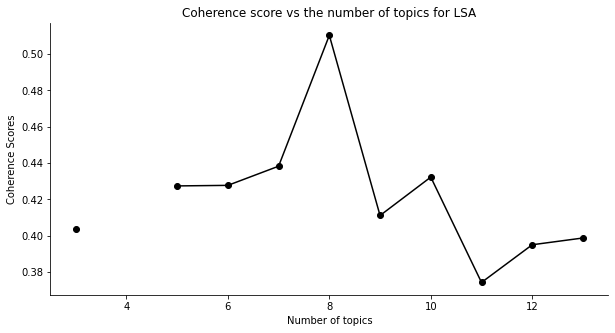

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(list(range(3,15)), scores_lsi, marker='o', color='black')
sns.despine(top=True, right=True, left=False, bottom=False)

plt.locator_params(integer=True)
plt.title('Coherence score vs the number of topics for LSA')
plt.xlabel('Number of topics')
plt.ylabel('Coherence Scores')
plt.savefig('lda_scores.jpg')
plt.show()

In [17]:
selected_topics_lsi = np.nanargmax(scores_lsi)+3
lsi_model = LsiModel(  corpus=corpus_tfidf, num_topics=selected_topics_lsi,
                                                 id2word=dct)
lsi_model.print_topics()

[(0,
  '0.577*"poupon" + 0.577*"grey" + 0.500*"like" + 0.289*"gettin" + 0.011*"cold" + 0.011*"common" + 0.010*"symptom" + 0.006*"covid" + 0.005*"routine" + 0.005*"majority"'),
 (1,
  '-0.469*"cold" + -0.468*"common" + -0.444*"symptom" + -0.236*"routine" + -0.235*"majority" + -0.235*"similar" + -0.232*"present" + -0.225*"testing" + -0.224*"mild" + -0.204*"people"'),
 (2,
  '0.473*"covid" + 0.418*"analytics" + 0.209*"usafacts" + 0.209*"datavisualization" + 0.209*"datascience" + 0.209*"globalhealth" + 0.208*"growth" + 0.208*"publichealth" + 0.208*"insight" + 0.207*"county"'),
 (3,
  '-0.700*"moderna" + -0.360*"candidate" + -0.360*"address" + -0.327*"booster" + -0.325*"via" + -0.194*"variant" + -0.008*"case" + -0.007*"new" + -0.006*"say" + -0.006*"vaccine"'),
 (4,
  '-0.492*"case" + -0.398*"variant" + -0.306*"new" + -0.198*"first" + -0.170*"coronavirus" + -0.167*"two" + -0.165*"detected" + -0.146*"omicronvariant" + -0.136*"say" + -0.123*"travel"'),
 (5,
  '0.679*"eth" + 0.361*"think" + 0.3

<b> Best Model Analysis </b> <br>
On the basis of coherence scores lda model have been chosen as the best model for the current data set

In [18]:
# judged manually from pyldavis
topics_name = ['Topic 1', 'Topic 2', 'Topic 3']

# getting the most dominant topics from a trained model
predicted_topics = lda_model[corpus_tfidf]

probs, topics = [], []
for k in predicted_topics:
  # sorting the probabilites
  k.sort(key=lambda x:x[1])
  # selecting the topic with greates probability
  topics.append(topics_name[ k[0][0] ] )

data['Topics'] = topics
data.head(2)

,tweet_id,date,text,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,hashtags,source,is_retweet,processed,Lengths,Topics
0,1465162850457071621,2021-11-29 03:36:59+00:00,Will Boris Johnson ever learn his lesson after...,James robertson,NaN,NaN,2013-04-22 19:41:30+00:00,303.0,188,84059,NaN,Twitter for Android,False,boris johnson ever learn lesson endless covid ...,10,Topic 1
1,1465162841665769474,2021-11-29 03:36:57+00:00,#Omicron so hot; it’s being rush shipped in De...,Gene Bulmer,East Coast,"#ChristFollower, #Leader, Husband, Father, #Ru...",2014-11-10 22:43:27+00:00,99.0,162,745,['Omicron'],Twitter for iPhone,False,omicron rush shipped package symptom barely kn...,9,Topic 1


(6233, 16)
(1738, 16)
(95, 16)


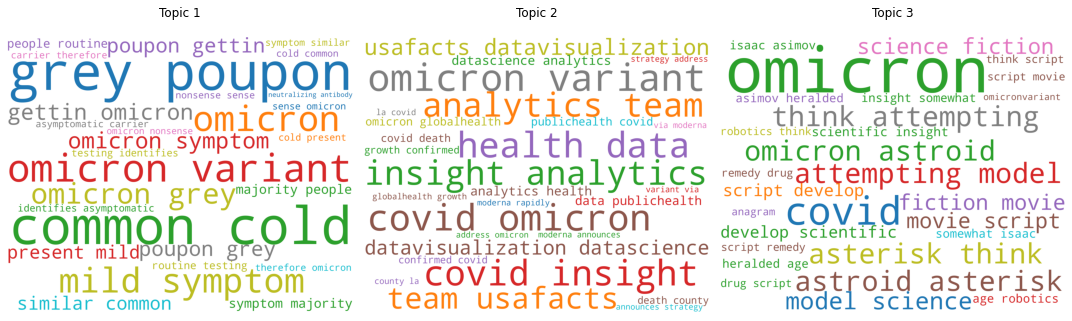

In [19]:
# 1. Wordcloud of Top N words in each topic

from matplotlib import pyplot as plt
from wordcloud import WordCloud

cloud = WordCloud(background_color='white', width=2500, height=2000,
                  max_words=28, colormap='tab10', prefer_horizontal=1.0)
  
fig, axes = plt.subplots(1, 3, figsize=(15,8), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
  
  fig.add_subplot(ax)
  if i>len(topics_name)-1:
    continue
  curr = data[data['Topics']==topics_name[i]]
  print(curr.shape)
  tokens = [tok for d in curr['processed'] for tok in d.split(' ')]
  cloud.generate(' '.join( tokens ))
      
  plt.gca().imshow(cloud)
  plt.gca().set_title( topics_name[i]+'\n')
  plt.gca().axis('off')

plt.axis('off')
plt.tight_layout()
plt.show()

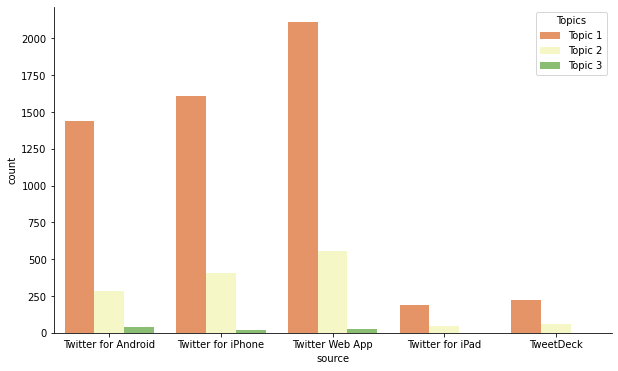

In [20]:
def subcategory_plot(df, col):
    
    plt.figure(figsize=(10,6))
    bar_pub = list( df[col].value_counts().index[:5] )
    temp2 = df[df[col].isin(bar_pub)]

    sns.countplot(x=col, hue='Topics', data=temp2, palette="RdYlGn")
    sns.despine()

    plt.savefig('bars_{}.png'.format(col))
    plt.show()

subcategory_plot(data, 'source')

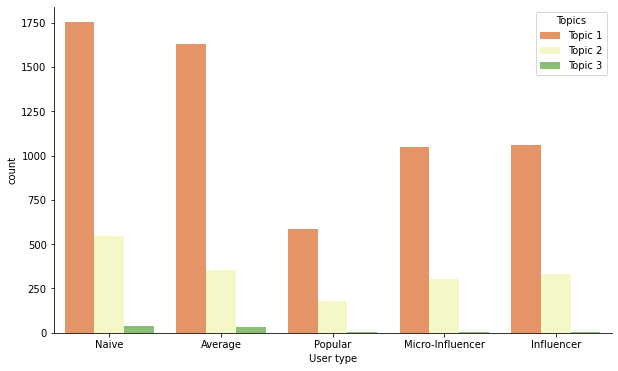

In [21]:
# users have been categorized according to their number of followers
data['User type']=pd.cut(data.user_followers, [1,200, 1000, 2000, 10000, 100000000], 
                             labels=['Naive', 'Average', 'Popular', 'Micro-Influencer', 'Influencer'])

subcategory_plot(data, 'User type')